In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
from tqdm import tqdm
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import matthews_corrcoef
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../decode/FracTAL_ResUNet/models/semanticsegmentation')
sys.path.append('../../decode/FracTAL_ResUNet/nn/loss')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

# from resunet_d6_causal_mtskcolor_ddist import *
# from resunet_d7_causal_mtskcolor_ddist import *
from FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from datasets import *

# Helper functions

In [3]:
def dice_coef(x, y):
    if type(x).__module__ == 'numpy':
        intersection = np.logical_and(x, y)
        return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
    else:
        intersection = mx.ndarray.op.broadcast_logical_and(x, y)
        return 2. * mx.nd.sum(intersection) / (mx.nd.sum(x) + mx.nd.sum(y))

In [4]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Load model

In [5]:
# ==================== USER SETTINGS ==================== #

# === MODELS TRAINED ON MONTHS SEPARATELY === #
# === FULL LABELS FRANCE === #
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/'
file_name = '../experiments/full-france/{}/model.params'.format(model_name)

# === PARTIAL LABELS FRANCE === #
# model_name = 'resunet-d6_2019_10_nfilter-16_bs-8_lr-0.001_4x-downsampled_allfield_n6759/'
# model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759'
# model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/'
# model_name = 'fractal-resunet_3month-separate_nfilter-32,_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759'
# file_name = '../experiments/partial-france/{}/model.params'.format(model_name)

# === INDIA FROM SCRATCH === #
# model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_fromscratch/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)

# === INDIA FINE-TUNED === #
# model_name = 'resunet-d6_dec_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned'
# model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_2x-downsampled-erosion1px_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_original-resolution_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2'
# file_name = '../experiments/india/{}/model.params'.format(model_name)

# === MODELS TRAINED ON MONTHS STACKED === #
# === PARTIAL LABELS FRANCE === #
# model_name = 'fractal-resunet_3month-stacked-shuffled_nfilter-32_depth-6_bs-6_lr-0.001_1x-downsampled_fromscratch/'
# model_name = 'fractal-resunet_3month-stacked-shuffled_nfilter-32_depth-6_bs-6_lr-0.001_2x-3x-downsampled_fromscratch/'
# file_name = '../experiments/partial-france/{}/model.params'.format(model_name)

# === INDIA FROM SCRATCH === #
# model_name = 'fractal-resunet_OctDecFeb-stacked-shuffled_nfilter-32_depth-6_bs-6_lr-0.001_fromscratch/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)

# === INDIA FINE-TUNED === #
# model_name = 'fractal-resunet_OctDecFeb-stacked-shuffled_nfilter-32_bs-6_lr-0.001_France-2x-3x-downsampled-finetuned/'
# model_name = 'fractal-resunet_OctDecFeb-stacked-shuffled_nfilter-32_bs-6_lr-0.001_France-1x-downsampled-finetuned/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)


# === DATASET SIZE EXPERIMENTS === #
# === PLANET FROM SCRATCH === #

# === PLANET FINE-TUNED === #
# model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n400_finetuned/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)

# === AIRBUS FINE-TUNED === #
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n1000_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n400_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n200_finetuned/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n40_finetuned-continued/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.0001_original-resolution_n20_finetuned-continued/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)

# === AIRBUS FROM SCRATCH === #
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n1000_fromscratch/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n400_fromscratch/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n200_fromscratch/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n40_fromscratch-continued/'
# model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-8_lr-0.001_original-resolution_n20_fromscratch-continued/'
# file_name = '../experiments/india/{}/model.params'.format(model_name)


n_filters = 32
depth = 6
n_classes = 1
n_channels = 3
batch_size = 8
codes_to_keep = [1]
boundary_kernel_size = (2,2)
ctx_name = 'gpu' #'gpu'
gpu = 0

# model = ResUNet_d6(_nfilters_init=n_filters, 
#                    _NClasses=n_classes,
#                    hsv_outchannels=hsv_channels)

model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)
if ctx_name == 'gpu':
    model.load_parameters(file_name, ctx=mx.gpu(gpu)) # mx.cpu())
elif ctx_name == 'cpu':
    model.load_parameters(file_name, ctx=mx.cpu())
# ======================================================= #

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


# Run India images through model

## Planet

### 12-month separate

In [9]:
# months = ['2020_{}'.format(str(x).zfill(2)) for x in range(8, 13)] + \
#          ['2021_{}'.format(str(x).zfill(2)) for x in range(1, 8)]
months = ['2020_10', '2020_12', '2021_02']

splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []

fold = 'test' # 'val'
img_dir = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_{}/'.format(fold)
label_dir = '../data/planet/india/GeneralBlockchain/extent_labels_{}/'.format(fold)
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values

label_folder_imgs = sorted(os.listdir(label_dir))
for month in months:
    for label_name in label_folder_imgs:
        img_name = label_name.split('.')[0] + '_' + month + '.tif'
        img_path = os.path.join(img_dir, month, img_name)
        all_img_names.append(img_path)
        label_path = os.path.join(label_dir, label_name)
        all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[0])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == fold]['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names_label = all_labels[all_labels['fold'] == fold]['label_path'].values

test_dataset = AirbusMasked(
    fold=fold, 
    image_names=test_names, 
    label_names=test_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
for month in months:
    save_dir = '../results/india/GeneralBlockchain/{}/{}'.format(model_name, month)
#     save_dir = '../results/india/GeneralBlockchain/full-france_{}/{}'.format(model_name, month)

    if not os.path.exists(save_dir):
        os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
        os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):
#         print("    ", i)

        # save predictions
        save_month = test_names[batch_i * batch_size + i].split('/')[-2]
#         print("save_month", save_month)
        save_dir = os.path.join('../results/india/GeneralBlockchain/{}'.format(model_name), save_month)
#         save_dir = os.path.join('../results/india/GeneralBlockchain/full-france_{}'.format(model_name), save_month)
#         print("save_dir", save_dir)
        image_id = test_names[gpustatbatch_i * batch_size + i].split('/')[-1][:-4]
#         print("image_id", image_id)
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i][0])
#         print("here")
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i][0])

    batch 0
    batch 10
    batch 20
    batch 30
    batch 40
    batch 50
    batch 60
    batch 70
    batch 80
    batch 90
    batch 100
    batch 110
    batch 120
    batch 130
    batch 140


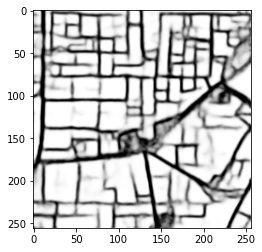

In [14]:
plt.imshow(logits[i][0], cmap='Greys_r')
plt.show()

### 3-month stacked

In [24]:
months = ['2020_10', '2020_12', '2021_02']
image_directories = ['../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_test/' 
                     + month for month in months]
label_dir = '../data/planet/india/GeneralBlockchain/extent_labels_test/'
image_suffixes = ['_' + x + '.tif' for x in months]

splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []
label_folder_imgs = sorted(os.listdir(os.path.join(label_dir)))
for label_name in label_folder_imgs:
    img_name = label_name.split('.')[0]
    all_img_names.append(img_name)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'image_id_new': all_img_names})
all_images['image_id'] = all_images['image_id_new'].str[:5]
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == 'test']['image_id_new'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id_new'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels['image_id'] = all_labels['image_id_new'].str[:5]
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values

test_dataset = MultitempMasked(
        image_directories=image_directories,
        fold='test', 
        image_names=test_names, 
        label_names=test_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size,
        n_channels=n_channels,
        image_suffixes=image_suffixes)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [25]:
for month in months:
    save_dir = '../results/india/GeneralBlockchain/{}'.format(model_name)

    if not os.path.exists(os.path.join(save_dir, 'extent_predictions')) or \
    not os.path.exists(os.path.join(save_dir, 'boundary_predictions')):
        os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
        os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):
#         print("    ", i)

        # save predictions
#         print("save_month", save_month)
        save_dir = '../results/india/GeneralBlockchain/{}'.format(model_name)
#         print("save_dir", save_dir)
        image_id = test_names[batch_i * batch_size + i]
#         print("image_id", image_id)
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i][0])
#         print("here")
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i][0])

    batch 0
    batch 10
    batch 20
    batch 30
    batch 40
    batch 50


## Airbus

### 3x downsampled

In [6]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []

fold = 'test'
img_dir = '../data/general_blockchain/airbus_false_color/large/3x_downsample_{}/'.format(fold)
label_dir = '../data/general_blockchain/airbus_labels/large/3x_downsample_erosion2px_{}/'.format(fold)
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values

label_folder_imgs = sorted(os.listdir(label_dir))
for label_name in label_folder_imgs:
    img_name = label_name
    img_path = os.path.join(img_dir, img_name)
    all_img_names.append(img_path)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == fold]['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names_label = all_labels[all_labels['fold'] == fold]['label_path'].values

test_dataset = AirbusMasked(
    fold='test',# fold, 
    image_names=test_names, 
    label_names=test_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
save_dir = '../results/india/GeneralBlockchain/{}/Airbus_3x_downsampled'.format(model_name)

if not os.path.exists(save_dir):
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):

        # save predictions
        save_dir = os.path.join('../results/india/GeneralBlockchain/{}'.format(model_name), 'Airbus_3x_downsampled')
        image_id = test_names[batch_i * batch_size + i].split('/')[-1][:-4]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i][0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i][0])

### 2x downsampled

In [14]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []

fold = 'test'
img_dir = '../data/general_blockchain/airbus_false_color/large/2x_downsample_{}/'.format(fold)
label_dir = '../data/general_blockchain/airbus_labels/large/2x_downsample_erosion1px_{}/'.format(fold)
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values

label_folder_imgs = sorted(os.listdir(label_dir))
for label_name in label_folder_imgs:
    img_name = label_name
    img_path = os.path.join(img_dir, img_name)
    all_img_names.append(img_path)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == fold]['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names_label = all_labels[all_labels['fold'] == fold]['label_path'].values

test_dataset = AirbusMasked(
    fold='test',# fold, 
    image_names=test_names, 
    label_names=test_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [15]:
save_dir = '../results/india/GeneralBlockchain/{}/Airbus_2x_downsampled'.format(model_name)

if not os.path.exists(save_dir):
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):

        # save predictions
        save_dir = os.path.join('../results/india/GeneralBlockchain/{}'.format(model_name), 'Airbus_2x_downsampled')
        image_id = test_names[batch_i * batch_size + i].split('/')[-1][:-4]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i][0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i][0])

    batch 0
    batch 10
    batch 20
    batch 30
    batch 40


### Original resolution

In [8]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []

fold = 'test' # 'val'
img_dir = '../data/general_blockchain/airbus_false_color/large/original_{}/'.format(fold)
label_dir = '../data/general_blockchain/airbus_labels/large/original_{}/'.format(fold)
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values

label_folder_imgs = sorted(os.listdir(label_dir))
for label_name in label_folder_imgs:
    img_name = label_name
    img_path = os.path.join(img_dir, img_name)
    all_img_names.append(img_path)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == fold]['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names_label = all_labels[all_labels['fold'] == fold]['label_path'].values

test_dataset = AirbusMasked(
    fold='test',# fold, 
    image_names=test_names, 
    label_names=test_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
save_dir = '../results/india/GeneralBlockchain/{}/Airbus_original'.format(model_name)

if not os.path.exists(save_dir):
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):

        # save predictions
        save_dir = os.path.join('../results/india/GeneralBlockchain/{}'.format(model_name), 'Airbus_original')
        image_id = test_names[batch_i * batch_size + i].split('/')[-1][:-4]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i][0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i][0])

## Entire images tiled

In [6]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

# get all img and labels
all_img_names = []
all_label_names = []

fold = 'test' # 'val'
# img_dir = '../data/general_blockchain/airbus_false_color/large/2x_downsample_{}/'.format(fold)
# label_dir = '../data/general_blockchain/airbus_labels/large/2x_downsample_erosion1px_{}/'.format(fold)
img_dir = '../data/general_blockchain/airbus_false_color/large/original_{}/'.format(fold)
# label_dir = '../data/general_blockchain/airbus_labels/large/original_{}/'.format(fold)
label_dir = '../data/general_blockchain/airbus_labels/large/original/'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values

img_folder_imgs = sorted(os.listdir(img_dir))
for img_name in img_folder_imgs:
    if '_x' and '_y' in img_name:
        img_path = os.path.join(img_dir, img_name)
        all_img_names.append(img_path)
        label_name = img_name[:20] + '.png'
        label_path = os.path.join(label_dir, label_name)
        all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[2][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
test_names = all_images[all_images['fold'] == fold]['img_path'].values

# all_labels = pd.DataFrame({'label_path': all_label_names})
# all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
#     lambda x: x[-1]).str.split('.').apply(
#     lambda x: x[0]).str.split('_').apply(
#     lambda x: x[2][1:])
# all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
# test_names_label = all_labels[all_labels['fold'] == fold]['label_path'].values
test_names_label = ['../data/general_blockchain/airbus_labels/large/original_test/airbus_geowiki_C0000.png'] * len(test_names)

test_dataset = AirbusMasked(
    fold='test',# fold, 
    image_names=test_names, 
    label_names=test_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# resolution_folder = 'Airbus_2x_downsampled'
resolution_folder = 'Airbus_original'
save_dir = '../results/india/GeneralBlockchain/full-france_{}/{}'.format(model_name, resolution_folder)

if not os.path.exists(save_dir):
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(test_dataloader):

    if batch_i % 10 == 0:
        print("    batch {}".format(batch_i))
#     if batch_i < 4350: continue

    if ctx_name == 'gpu':
        img = img.as_in_context(mx.gpu(gpu))
    elif ctx_name == 'cpu':
        img = img.as_in_context(mx.cpu())
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):

        # save predictions
        save_dir = os.path.join('../results/india/GeneralBlockchain/', 'full-france_' + model_name, resolution_folder)
        image_id = test_names[batch_i * batch_size + i].split('/')[-1][:-4]
        extent_uint8 = np.array(logits[i][0] * 255, dtype=np.uint8)
        bound_uint8 = np.array(bound[i][0] * 255, dtype=np.uint8)
        imageio.imwrite(os.path.join(save_dir, 'extent_predictions/{}.png'.format(image_id)), extent_uint8)
        imageio.imwrite(os.path.join(save_dir, 'boundary_predictions/{}.png'.format(image_id)), bound_uint8)

    batch 0
    batch 10
    batch 20
    batch 30
    batch 40
    batch 50
    batch 60
    batch 70
    batch 80
    batch 90
    batch 100
    batch 110
    batch 120
    batch 130
    batch 140
    batch 150
    batch 160
    batch 170
    batch 180
    batch 190
    batch 200
    batch 210
    batch 220
    batch 230
    batch 240
    batch 250
    batch 260
    batch 270
    batch 280
    batch 290
    batch 300
    batch 310
    batch 320
    batch 330
    batch 340
    batch 350
    batch 360
    batch 370
    batch 380
    batch 390
    batch 400
    batch 410
    batch 420
    batch 430
    batch 440
    batch 450
    batch 460
    batch 470
    batch 480
    batch 490
    batch 500
    batch 510
    batch 520
    batch 530
    batch 540
    batch 550
    batch 560
    batch 570
    batch 580
    batch 590
    batch 600
    batch 610
    batch 620
    batch 630
    batch 640
    batch 650
    batch 660
    batch 670
    batch 680
    batch 690
    batch 700
    batch 710
   

    batch 5540
    batch 5550
    batch 5560
    batch 5570
    batch 5580
    batch 5590
    batch 5600
    batch 5610
    batch 5620
    batch 5630
    batch 5640
    batch 5650
    batch 5660
    batch 5670
    batch 5680
    batch 5690
    batch 5700
    batch 5710
    batch 5720
    batch 5730
    batch 5740
    batch 5750
    batch 5760
    batch 5770
    batch 5780
    batch 5790
    batch 5800
    batch 5810
    batch 5820
    batch 5830
    batch 5840
    batch 5850
    batch 5860
    batch 5870
    batch 5880
    batch 5890
    batch 5900
    batch 5910
    batch 5920
    batch 5930
    batch 5940
    batch 5950
    batch 5960
    batch 5970
    batch 5980
    batch 5990
    batch 6000
    batch 6010
    batch 6020
    batch 6030


In [11]:
print("done")

done


In [24]:
img = imageio.imread('../data/general_blockchain/airbus_false_color/large/original_train/airbus_geowiki_C0005_x000_y000.png')

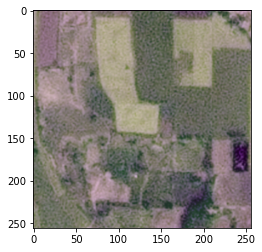

In [26]:
plt.imshow(img)
plt.show()

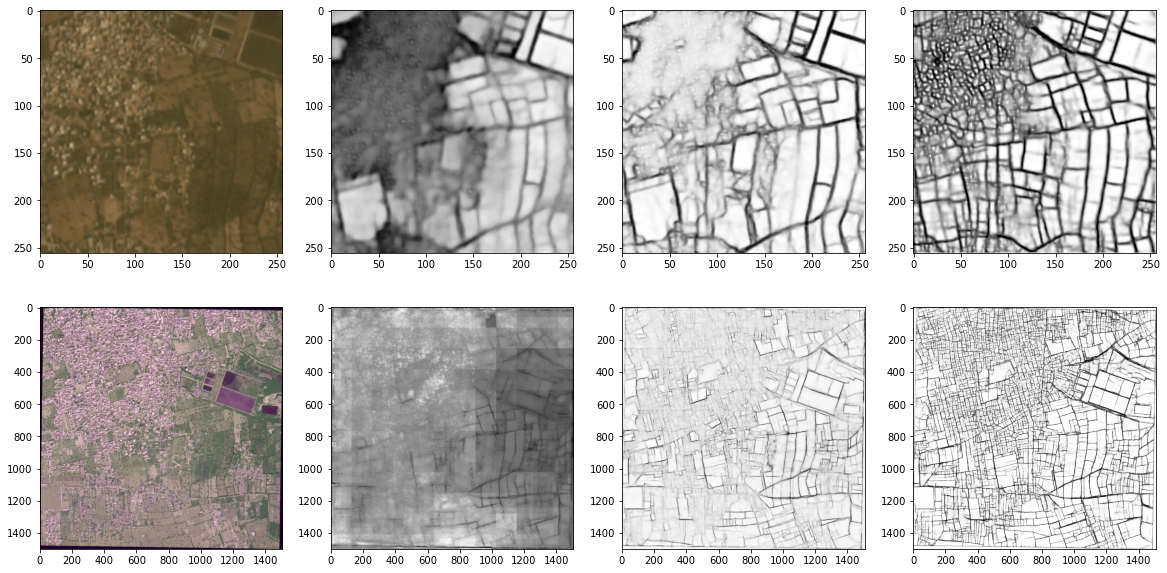

In [31]:
img_id = '0000'

planet_img = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_test/2020_10/{}_2020_10.tif'.format(img_id))
planet_pred1 = np.load('../results/india/GeneralBlockchain/full-france_fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_OctDecFeb/extent_predictions/{}.npy'.format(img_id))
planet_pred2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(img_id))
planet_pred3 = np.load('../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/2020_10/extent_predictions/{}_2020_10.npy'.format(img_id))

airbus_img = imageio.imread('../data/general_blockchain/airbus_false_color/large/original/airbus_geowiki_C{}.png'.format(img_id))
airbus_pred1 = imageio.imread('../results/india/GeneralBlockchain/full-france_fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(img_id))
airbus_pred2 = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(img_id))
airbus_pred3 = imageio.imread('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original/extent_full/airbus_geowiki_C{}.png'.format(img_id))

fig, ax = plt.subplots(2, 4, figsize=(20,10))
ax[0,0].imshow(planet_img)
ax[0,1].imshow(planet_pred1, cmap='Greys_r')
ax[0,2].imshow(planet_pred2, cmap='Greys_r')
ax[0,3].imshow(planet_pred3, cmap='Greys_r')

ax[1,0].imshow(airbus_img)
ax[1,1].imshow(airbus_pred1, cmap='Greys_r')
ax[1,2].imshow(airbus_pred2, cmap='Greys_r')
ax[1,3].imshow(airbus_pred3, cmap='Greys_r')
plt.show()